# Principal Component Analysis in 3 Simple Steps

Principal Component Analysis (PCA) is a simple yet popular and useful linear transformation technique that is used in numerous applications, such as stock market predictions, the  analysis of gene expression data, and many more. In this tutorial, we will see that PCA is not just a "black box", and we are going to unravel its internals in 3 basic steps.

This article just got a complete overhaul, the original version is still available at [principal_component_analysis_old.ipynb](http://nbviewer.ipython.org/github/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/principal_component_analysis.ipynb).

<br>
<br>

<hr>

## Sections

- [Introduction](#Introduction)
    - [PCA Vs. LDA](#PCA-Vs.-LDA)
    - [PCA and Dimensionality Reduction](#PCA-and-Dimensionality-Reduction)
    - [A Summary of the PCA Approach](#A-Summary-of-the-PCA-Approach)
- [Preparing the Iris Dataset](#Preparing-the-Iris-Dataset)
    - [About Iris](#About-Iris)
    - [Loading the Dataset](#Loading-the-Dataset)
    - [Exploratory Visualization](#Exploratory-Visualization)
    - [Standardizing](#Standardizing)
- [1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues](#1---Eigendecomposition---Computing-Eigenvectors-and-Eigenvalues)
    - [Covariance Matrix](#Covariance-Matrix)
    - [Correlation Matrix](#Correlation-Matrix)
    - [Singular Vector Decomposition](#Singular-Vector-Decomposition)
- [2 - Selecting Principal Components](#2---Selecting-Principal-Components)
    - [Sorting Eigenpairs](#Sorting-Eigenpairs)
    - [Explained Variance](#Explained-Variance)
    - [Projection Matrix](#Projection-Matrix)
- [3 - Projection Onto the New Feature Space](#3---Selecting-Principal-Components)
- [Shortcut - PCA in scikit-learn](#Shortcut---PCA-in-scikit-learn)

<br>
<br>

<hr>

## Introduction

[[back to top](#Sections)]

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

<br>
<br>

### PCA Vs. LDA

[[back to top](#Sections)]

Both Linear Discriminant Analysis (LDA) and PCA are linear transformation methods. PCA yields the directions (principal components) that maximize the variance of the data, whereas LDA also aims to find the directions that maximize the separation (or discrimination) between different classes, which can be useful in pattern classification problem (PCA "ignores" class labels).   
***In other words, PCA projects the entire dataset onto a different feature (sub)space, and LDA tries to determine a suitable feature (sub)space in order to distinguish between patterns that belong to different classes.***  

<br>
<br>

### PCA and Dimensionality Reduction

[[back to top](#Sections)]

Often, the desired goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$) in order to increase the computational efficiency while retaining most of the information. An important question is "what is the size of $k$ that represents the data 'well'?"

Later, we will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the "length" or "magnitude" of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the "less informative" eigenpairs is reasonable.


<br>
<br>

### A Summary of the PCA Approach

[[back to top](#Sections)]

-  Standardize the data.
-  Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
-  Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \le d$)/.
-  Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
-  Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace $\mathbf{Y}$.

<br>
<br>

## Preparing the Iris Dataset

[[back to top](#Sections)]

<br>
<br>

### About Iris

[[back to top](#Sections)]

For the following tutorial, we will be working with the famous "Iris" dataset that has been deposited on the UCI machine learning repository   
([https://archive.ics.uci.edu/ml/datasets/Iris](https://archive.ics.uci.edu/ml/datasets/Iris)).

The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset are:

1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

And the four features of in Iris dataset are:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm



<br>
<br>

### Loading the Dataset

[[back to top](#Sections)]

In order to load the Iris data directly from the UCI repository, we are going to use the superb [pandas](http://pandas.pydata.org) library. If you haven't used pandas yet, I want encourage you to check out the [pandas tutorials](http://pandas.pydata.org/pandas-docs/stable/tutorials.html). If I had to name one Python library that makes working with data a wonderfully simple task, this would definitely be pandas!

In [2]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [5]:
# split data table into data X and class labels y

X = df.ix[:,0:4].values
y = df.ix[:,4].values
print(X[:3])
print(y[:3])

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]]
['Iris-setosa' 'Iris-setosa' 'Iris-setosa']


Our iris dataset is now stored in form of a  $150 \times 4$ matrix where the columns are the different features, and every row represents a separate flower sample.
Each sample row $\mathbf{x}$ can be pictured as a 4-dimensional vector   


$\mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} 
= \begin{pmatrix} \text{sepal length} \\ \text{sepal width} \\\text{petal length} \\ \text{petal width} \end{pmatrix}$

<br>
<br>

### Exploratory Visualization

[[back to top](#Sections)]

To get a feeling for how the 3 different flower classes are distributes along the 4 different features, let us visualize them via histograms.

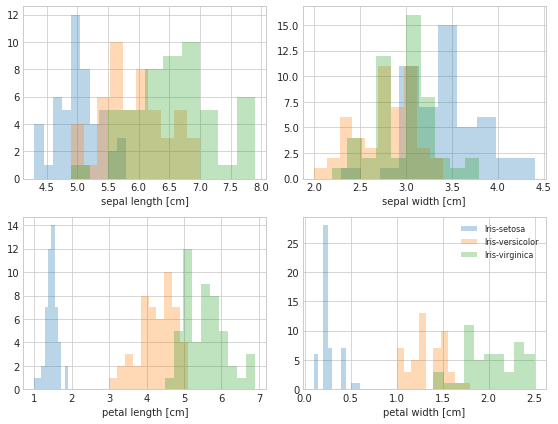

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

<br>
<br>

### Standardizing

[[back to top](#Sections)]

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [8]:
# TODO - use StandardScaler on our data
# X_std = ...
from sklearn import preprocessing
X_std = preprocessing.scale(X)
X_std

array([[ -9.00681170e-01,   1.03205722e+00,  -1.34127240e+00,
         -1.31297673e+00],
       [ -1.14301691e+00,  -1.24957601e-01,  -1.34127240e+00,
         -1.31297673e+00],
       [ -1.38535265e+00,   3.37848329e-01,  -1.39813811e+00,
         -1.31297673e+00],
       [ -1.50652052e+00,   1.06445364e-01,  -1.28440670e+00,
         -1.31297673e+00],
       [ -1.02184904e+00,   1.26346019e+00,  -1.34127240e+00,
         -1.31297673e+00],
       [ -5.37177559e-01,   1.95766909e+00,  -1.17067529e+00,
         -1.05003079e+00],
       [ -1.50652052e+00,   8.00654259e-01,  -1.34127240e+00,
         -1.18150376e+00],
       [ -1.02184904e+00,   8.00654259e-01,  -1.28440670e+00,
         -1.31297673e+00],
       [ -1.74885626e+00,  -3.56360566e-01,  -1.34127240e+00,
         -1.31297673e+00],
       [ -1.14301691e+00,   1.06445364e-01,  -1.28440670e+00,
         -1.44444970e+00],
       [ -5.37177559e-01,   1.49486315e+00,  -1.28440670e+00,
         -1.31297673e+00],
       [ -1.26418478e

<br>
<br>

## 1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues

[[back to top](#Sections)]

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

<br>
<br>

### Covariance Matrix

[[back to top](#Sections)]

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$

We can summarize the calculation of the covariance matrix via the following matrix equation:   
$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$  
where $\mathbf{\bar{x}}$ is the mean vector 
$\mathbf{\bar{x}} = \sum\limits_{k=1}^n x_{i}.$  
The mean vector is a $d$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

In [32]:
import numpy as np

# TODO - calculate covariance matrix
cov_mat = np.cov(X_std)
#cov_mat[:1]

The more verbose way above was simply used for demonstration purposes, equivalently, we could have used the numpy `cov` function:

<br>
<br>

Next, we perform an eigendecomposition on the covariance matrix:

In [16]:
np.diag((1, 2, 3))

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [22]:
eigen_value, eigen_vector = np.linalg.eig(np.diag((1, 2, 3)))
print(eigen_vector)
print(eigen_value)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[ 1.  2.  3.]


In [24]:
cov_mat = np.cov(X_std.T)

# TODO - try np.linalg....
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


<br>
<br>

### Correlation Matrix

[[back to top](#Sections)]

Especially, in the field of "Finance," the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.


TODO - See also [here](http://stats.stackexchange.com/questions/62677/pca-on-correlation-or-covariance-does-pca-on-correlation-ever-make-sense)

<br>
<br>

Eigendecomposition of the standardized data based on the correlation matrix:

In [33]:
# TODO
# cor_mat1 = ....
#print(X_std[:1])
#print(X_std.T[:1][:1])
cor_mat1 = np.cov(X_std.T)


eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


<br>
<br>

Eigendecomposition of the raw data based on the correlation matrix:

In [35]:
import numpy as np

# TODO 
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)


print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)


Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.91081808  0.92122093  0.14735328  0.02060771]


<br>
<br>

We can clearly see that all three approaches yield the same eigenvectors and eigenvalue pairs:
    
- Eigendecomposition of the covariance matrix after standardizing the data.
- Eigendecomposition of the correlation matrix.
- Eigendecomposition of the correlation matrix after standardizing the data.

<br>
<br>

### Singular Vector Decomposition

[[back to top](#Sections)]

In [38]:
# TODO - SVD on X_std
# Whare are the three matrices again?
# u,s,v = ...
u,s,v = np.linalg.svd(X_std.T)
(s*s)/150


array([ 2.91081808,  0.92122093,  0.14735328,  0.02060771])

While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency. So, let us perform an SVD to  confirm that the result are indeed the same:

In [59]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X_std, n_components=1)

Sigma

array([ 20.89551896])

## 2 - Selecting Principal Components

[[back to top](#Sections)]

<br>
<br>

### Sorting Eigenpairs

[[back to top](#Sections)]

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [41]:
print(eig_vecs)
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
Everything ok!


<br>
<br>

In order to decide which eigenvector(s) can dropped without losing too much information
for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.  
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

In [43]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i)

Eigenvalues in descending order:
(2.9108180837520528, array([ 0.52237162, -0.26335492,  0.58125401,  0.56561105]))
(0.92122093070722544, array([-0.37231836, -0.92555649, -0.02109478, -0.06541577]))
(0.14735327830509579, array([-0.72101681,  0.24203288,  0.14089226,  0.6338014 ]))
(0.020607707235624842, array([ 0.26199559, -0.12413481, -0.80115427,  0.52354627]))


<br>
<br>

### Explained Variance

[[back to top](#Sections)]

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [44]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

Done


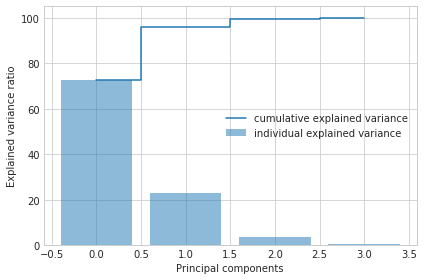

In [47]:
%matplotlib inline
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    print("Done")

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

<br>
<br>

### Projection Matrix

[[back to top](#Sections)]

It's about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" has a nice ring to it, it is basically just a matrix of our concatenated top *k* eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $\mathbf{W}$.

In [55]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


<br>
<br>

## 3 - Projection Onto the New Feature Space

[[back to top](#Sections)]

In this last step we will use the $4 \times 2$-dimensional projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation  
$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$, where $\mathbf{Y}$ is a $150\times 2$ matrix of our transformed samples.

In [56]:
Y = X_std.dot(matrix_w)

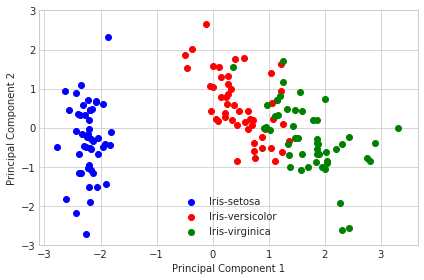

In [57]:

#from seaborn import plt
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

<br>
<br>
<a name="mat_pca"></a>

<br>
<br>
<a name="sklearn_pca"> </a>

## Shortcut - PCA in scikit-learn

[[back to top](#Sections)]

For educational purposes, we went a long way to apply the PCA to the Iris dataset. But luckily, there is already implementation in scikit-learn. 

In [58]:
# TODO - use sklearn's PCA with 2 components
# ...
# sklearn_pca = ...
# THEN call fit_transform on the standardised data
# Y_sklearn = ...

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std) # these are still data points

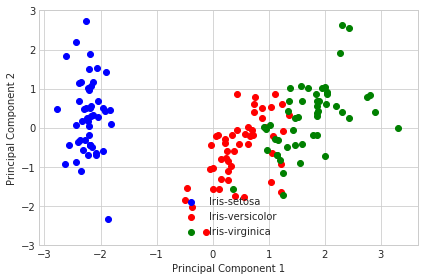

In [59]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()